<a href="https://colab.research.google.com/github/jejjohnson/research_notebook/blob/develop/research_notebook/content/notes/nfs/numpyro_nfs_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Example: Neural Transport

This example illustrates how to use a trained AutoBNAFNormal autoguide to transform a posterior to a
Gaussian-like one. The transform will be used to get better mixing rate for NUTS sampler.

**References:**

    1. Hoffman, M. et al. (2019), "NeuTra-lizing Bad Geometry in Hamiltonian Monte Carlo Using Neural Transport",
       (https://arxiv.org/abs/1903.03704)

<img src="file://../_static/img/examples/neutra.png" align="center">


In [1]:
#@title Install Packages
!pip install jax jaxlib chex optax distrax flax loguru corner
!pip install "git+https://github.com/deepmind/dm-haiku"
!pip install "git+https://github.com/pyro-ppl/numpyro.git"
!pip install tensorflow-probability

     |████████████████████████████████| 57 kB 2.7 MB/s 
     |████████████████████████████████| 118 kB 18.7 MB/s 
     |████████████████████████████████| 208 kB 44.6 MB/s 
     |████████████████████████████████| 183 kB 8.4 MB/s 
     |████████████████████████████████| 57 kB 3.8 MB/s 
  Cloning https://github.com/deepmind/dm-haiku to /tmp/pip-req-build-5og9zi92
  Running command git clone -q https://github.com/deepmind/dm-haiku /tmp/pip-req-build-5og9zi92
  Created wheel for dm-haiku: filename=dm_haiku-0.0.5.dev0-py3-none-any.whl size=532617 sha256=e744df8915c6260a24b2f70651cb79dda0dc73639bd2470c87b5f21d86c7449a
  Stored in directory: /tmp/pip-ephem-wheel-cache-37crhxuy/wheels/06/28/69/ebaac5b2435641427299f29d88d005fb4e2627f4a108f0bdbc
Successfully built dm-haiku
  Cloning https://github.com/pyro-ppl/numpyro.git to /tmp/pip-req-build-dn17f58g
  Running command git clone -q https://github.com/pyro-ppl/numpyro.git /tmp/pip-req-build-dn17f58g
  Created wheel for numpyro: filename=numpyro-0

In [3]:
import argparse
import os

from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import seaborn as sns

from jax import random
import jax.numpy as jnp
from jax.scipy.special import logsumexp

import numpyro
from numpyro import optim
from numpyro.diagnostics import print_summary
import numpyro.distributions as dist
from numpyro.distributions import constraints
from numpyro.infer import MCMC, NUTS, SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoBNAFNormal, AutoIAFNormal
from numpyro.infer.reparam import NeuTraReparam


In [4]:
# NUMPYRO SETTINGS
import numpyro
import numpyro.distributions as dist
from numpyro.infer.autoguide import AutoDiagonalNormal
from numpyro.infer import SVI, Trace_ELBO

# NUMPY SETTINGS
import numpy as np
np.set_printoptions(precision=3, suppress=True)

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)

# PANDAS SETTINGS
import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

# LOGGING SETTINGS
import loguru

%load_ext autoreload
%autoreload 2

In [9]:
class DualMoonDistribution(dist.Distribution):
    support = constraints.real_vector

    def __init__(self):
        super(DualMoonDistribution, self).__init__(event_shape=(2,))

    def sample(self, key, sample_shape=()):
        # it is enough to return an arbitrary sample with correct shape
        return jnp.zeros(sample_shape + self.event_shape)

    def log_prob(self, x):
        term1 = 0.5 * ((jnp.linalg.norm(x, axis=-1) - 2) / 0.4) ** 2
        term2 = -0.5 * ((x[..., :1] + jnp.array([-2.0, 2.0])) / 0.6) ** 2
        pe = term1 - logsumexp(term2, axis=-1)

        return -pe


def w1(z):
    return jnp.sin(2.0 * jnp.pi * z[..., 0] / 4.0)



class SineWaveDistribution(dist.Distribution):
    support = constraints.real_vector

    def __init__(self):
        super(SineWaveDistribution, self).__init__(event_shape=(2,))

    def sample(self, key, sample_shape=()):
        return jnp.zeros(sample_shape + self.event_shape)

    def log_prob(self, x):
        # print(x.shape)
        z = x
        p = 0.5 * ((z[..., 1] - w1(z)) / 0.4) ** 2 + 0.1 * jnp.abs(z[..., 0])
        print(p.shape)
        return -p


def w2(z):
    return 3.0 * jnp.exp(-0.5 * ((z[..., 0] - 1.0) / 0.6) ** 2)

class HoleWaveDistribution(dist.Distribution):
    support = constraints.real_vector

    def __init__(self):
        super(HoleWaveDistribution, self).__init__(event_shape=(2,))

    def sample(self, key, sample_shape=()):
        return jnp.zeros(sample_shape + self.event_shape)

    def log_prob(self, x):
        # print(x.shape)
        z = x
        pe = -jnp.log(
            jnp.exp(-0.5 * ((z[..., 1] - w1(z)) / 0.4) ** 2)
            + jnp.exp(-0.5 * ((z[..., 1] - w1(z) + w2(z)) / 0.35) ** 2)
        ) + 0.1 * jnp.abs(z[..., 0])
        return -pe

def w3(z):
    return 3.0 * (1 + jnp.exp(-(z[..., 0] - 1.0) / 0.3)) ** -1

class SplitWaveDistribution(dist.Distribution):
    support = constraints.real_vector

    def __init__(self):
        super(SplitWaveDistribution, self).__init__(event_shape=(2,))

    def sample(self, key, sample_shape=()):
        return jnp.zeros(sample_shape + self.event_shape)

    def log_prob(self, x):
        # print(x.shape)
        z = x
        pe = -jnp.log(
            jnp.exp(-0.5 * ((z[..., 1] - w1(z)) / 0.4) ** 2)
            + jnp.exp(-0.5 * ((z[..., 1] - w1(z) + w3(z)) / 0.35) ** 2)
        ) + 0.1 * jnp.abs(z[..., 0])
        return -pe

def dual_moon_model():
    numpyro.sample("x", DualMoonDistribution())


def dual_moon_model():
    numpyro.sample("x", DualMoonDistribution())

def sine_wave_model():
    numpyro.sample("x", SineWaveDistribution())

def hole_wave_model():
    numpyro.sample("x", HoleWaveDistribution())


def split_wave_model():
    numpyro.sample("x", SplitWaveDistribution())

## Samples

In [10]:
# 1. Plot samples drawn from BananaShaped distribution
demo_dist = "dualmoon"

# if demo_dist == "banana":

#     xlim = [-3, 3]
#     ylim = [0, 8]
#     param_a, param_b = 1.15, 1.1

#     d = BananaShaped(param_a, param_b)
    
if demo_dist == "dualmoon":
    xlim = [-3, 3]
    ylim = [-3, 3]

    d = DualMoonDistribution()
    model = dual_moon_model

elif demo_dist == "sinewave":
    xlim = [-5, 5]
    ylim = [-5, 5]

    d = SineWaveDistribution()
    model = sine_wave_model

elif demo_dist == "holewave":
    xlim = [-5, 5]
    ylim = [-5, 5]

    d = HoleWaveDistribution()
    model = hole_wave_model

elif demo_dist == "splitwave":
    xlim = [-5, 5]
    ylim = [-5, 5]

    d = SplitWaveDistribution()
    model = split_wave_model

x1, x2 = jnp.meshgrid(jnp.linspace(*xlim, 100), jnp.linspace(*ylim, 100))


p = jnp.exp(d.log_prob(jnp.stack([x1, x2], axis=-1)))

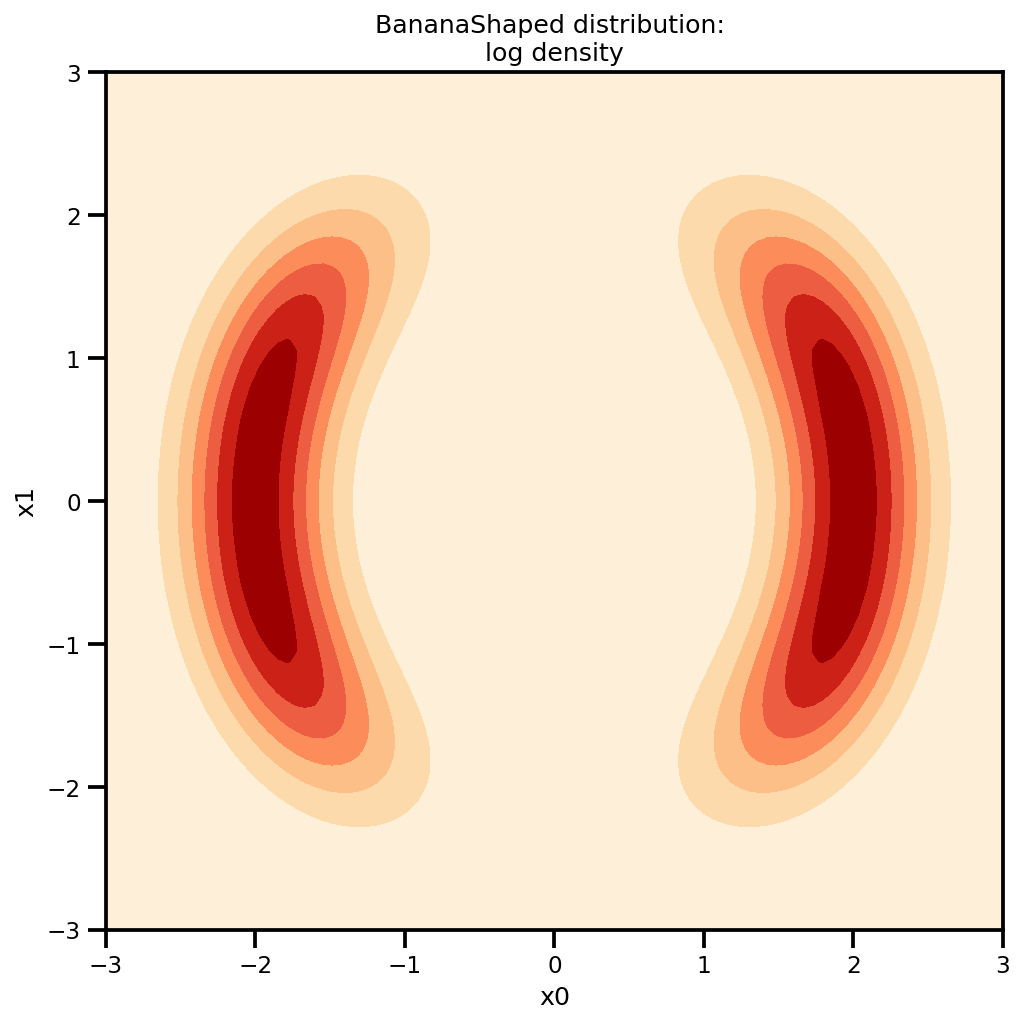

In [11]:
fig, ax = plt.subplots(figsize=(7, 7), constrained_layout=True)

ax.contourf(
    x1,
    x2,
    p,
    cmap="OrRd",
)
ax.set(
    xlabel="x0",
    ylabel="x1",
    xlim=xlim,
    ylim=ylim,
    title="BananaShaped distribution: \nlog density",
)
plt.show()


## VI - Standard

In [12]:
from numpyro.infer.autoguide import AutoDiagonalNormal

guide = AutoDiagonalNormal(model)
svi = SVI(model, guide, optim.Adam(0.02), Trace_ELBO())

In [13]:
num_iters = 10_000

print("Start training guide...")
svi_result = svi.run(random.PRNGKey(1), num_iters)

Start training guide...


100%|██████████| 10000/10000 [00:01<00:00, 7090.08it/s, init loss: 2.8514, avg. loss [9501-10000]: -0.9236]


In [14]:
num_samples = 1_000
print("Finish training guide. Extract samples...")
autodiag_samples = guide.sample_posterior(
    random.PRNGKey(2), svi_result.params, sample_shape=(num_samples,)
)["x"].copy()

Finish training guide. Extract samples...


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


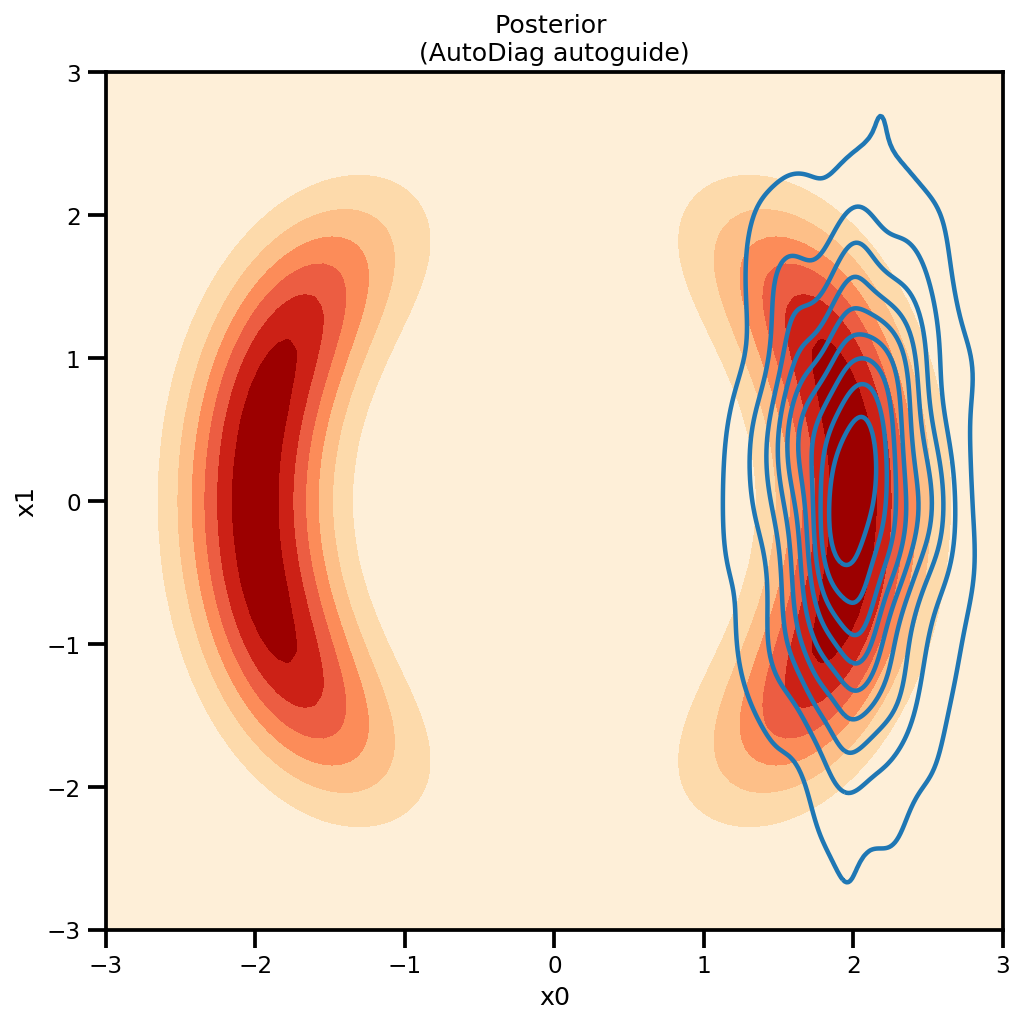

In [15]:
fig, ax = plt.subplots(figsize=(7, 7), constrained_layout=True)


ax.contourf(x1, x2, p, cmap="OrRd")
ax.set(
    xlabel="x0",
    ylabel="x1",
    xlim=xlim,
    ylim=ylim,
    title="Posterior \n(AutoDiag autoguide)",
)

sns.kdeplot(autodiag_samples[:, 0], autodiag_samples[:, 1], ax=ax)
plt.show()

## VI + Full Normal

In [16]:
from numpyro.infer.autoguide import AutoMultivariateNormal

guide = AutoMultivariateNormal(model)
svi = SVI(model, guide, optim.Adam(0.03), Trace_ELBO())

In [17]:
num_iters = 10_000

print("Start training guide...")
svi_result = svi.run(random.PRNGKey(1), num_iters)

Start training guide...


100%|██████████| 10000/10000 [00:01<00:00, 6215.08it/s, init loss: 2.8514, avg. loss [9501-10000]: -0.9044]


In [18]:
num_samples = 1_000
print("Finish training guide. Extract samples...")
autonormal_samples = guide.sample_posterior(
    random.PRNGKey(2), svi_result.params, sample_shape=(num_samples,)
)["x"].copy()

Finish training guide. Extract samples...


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


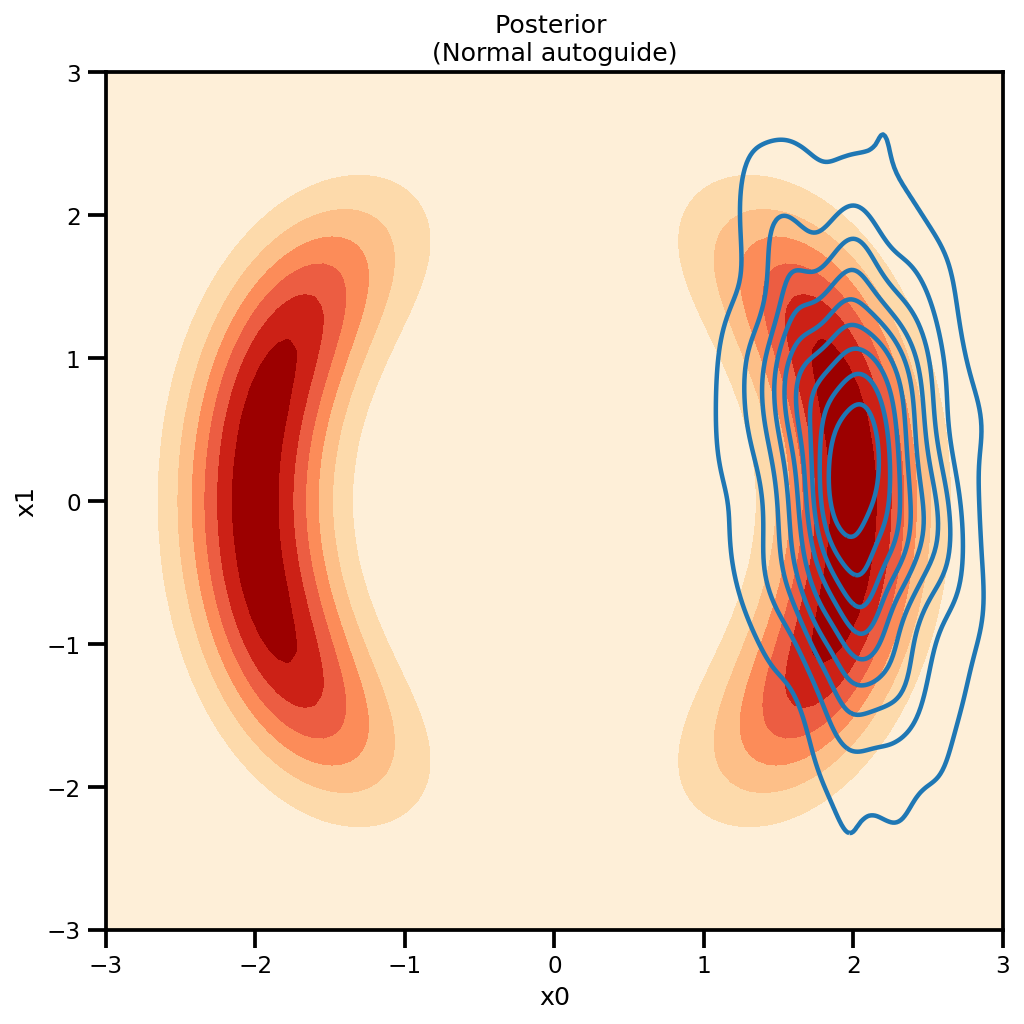

In [19]:
fig, ax = plt.subplots(figsize=(7, 7), constrained_layout=True)


ax.contourf(x1, x2, p, cmap="OrRd")
ax.set(
    xlabel="x0",
    ylabel="x1",
    xlim=xlim,
    ylim=ylim,
    title="Posterior \n(Normal autoguide)",
)

sns.kdeplot(autonormal_samples[:, 0], autonormal_samples[:, 1], ax=ax)
plt.show()

## VI + BNAF

In [41]:
guide = AutoBNAFNormal(
    model, hidden_factors=[8, 8], num_flows=1
)
svi = SVI(model, guide, optim.Adam(0.003), Trace_ELBO())

In [42]:
num_iters = 20_000


print("Start training guide...")
svi_result = svi.run(random.PRNGKey(1), num_iters)


Start training guide...


100%|██████████| 20000/20000 [00:05<00:00, 3676.16it/s, init loss: 1.5324, avg. loss [19001-20000]: -1.7992]


In [43]:
num_samples = 2_000
print("Finish training guide. Extract samples...")
autobnaf_samples = guide.sample_posterior(
    random.PRNGKey(2), svi_result.params, sample_shape=(num_samples,)
)["x"].copy()

Finish training guide. Extract samples...


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


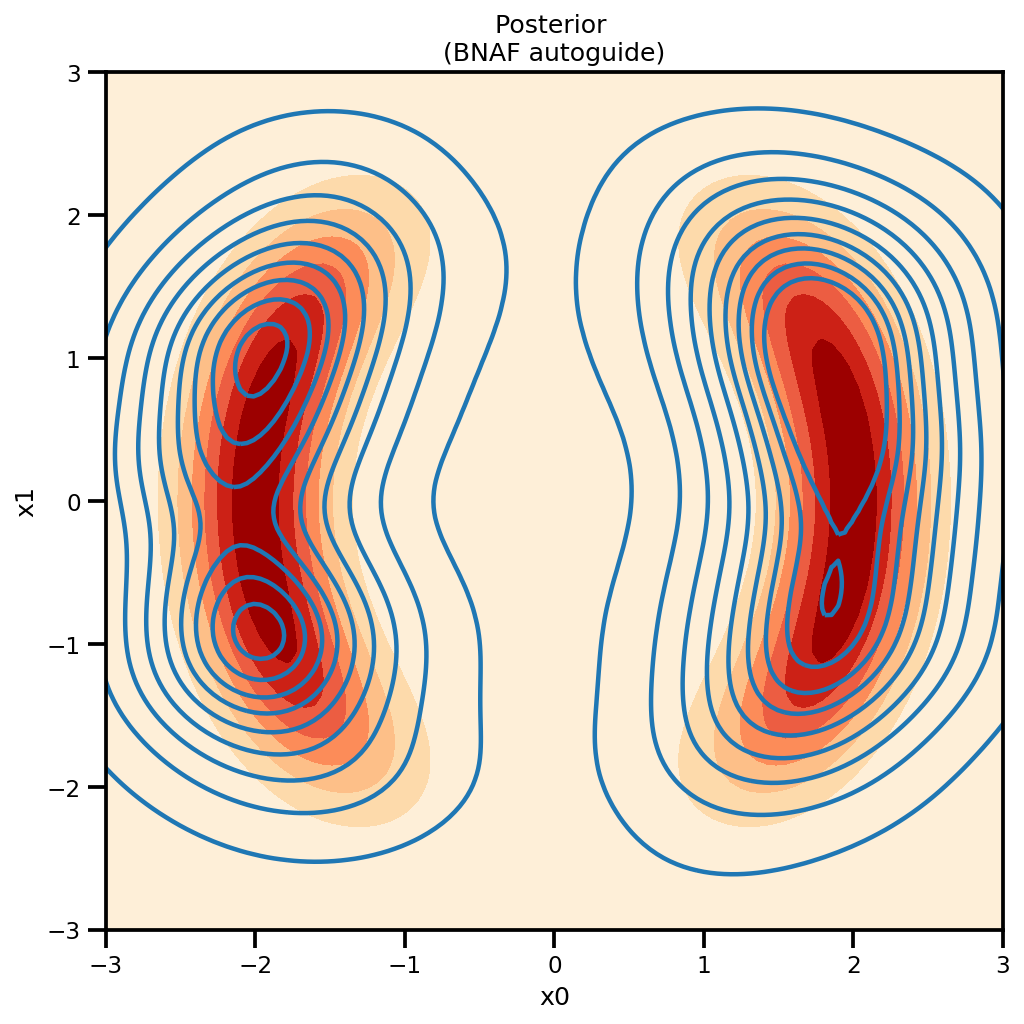

In [44]:
fig, ax = plt.subplots(figsize=(7, 7), constrained_layout=True)


ax.contourf(x1, x2, p, cmap="OrRd")
ax.set(
    xlabel="x0",
    ylabel="x1",
    xlim=xlim,
    ylim=ylim,
    title="Posterior \n(BNAF autoguide)",
)

sns.kdeplot(autobnaf_samples[:, 0], autobnaf_samples[:, 1], ax=ax)
plt.show()

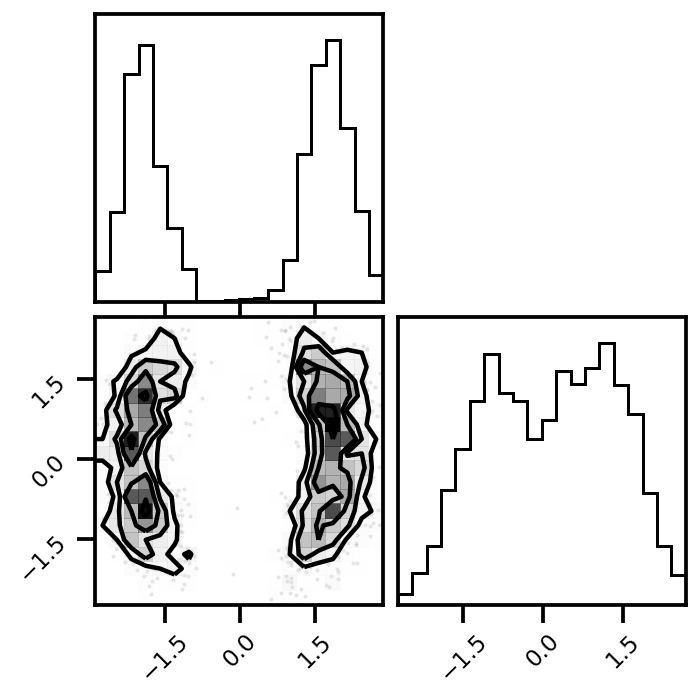

In [45]:
import corner

fig = corner.corner(autobnaf_samples)

## VI + IAF

In [46]:
from numpyro.infer import TraceMeanField_ELBO

In [75]:
hidden_dims = [32, 32]
skip_connections = False
num_flows = 8


guide = AutoIAFNormal(
    model, 
    hidden_dims=hidden_dims, 
    skip_connections=skip_connections,
    num_flows=num_flows
)

svi = SVI(model, guide, optim.Adam(0.003), Trace_ELBO())

In [76]:
num_iters = 50_000


print("Start training guide...")
svi_result = svi.run(random.PRNGKey(1), num_iters)


Start training guide...


100%|██████████| 50000/50000 [00:26<00:00, 1878.02it/s, init loss: 0.6367, avg. loss [47501-50000]: -1.0797]


In [77]:
num_samples = 1_000
print("Finish training guide. Extract samples...")
autoiaf_samples = guide.sample_posterior(
    random.PRNGKey(2), svi_result.params, sample_shape=(num_samples,)
)["x"].copy()

Finish training guide. Extract samples...


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


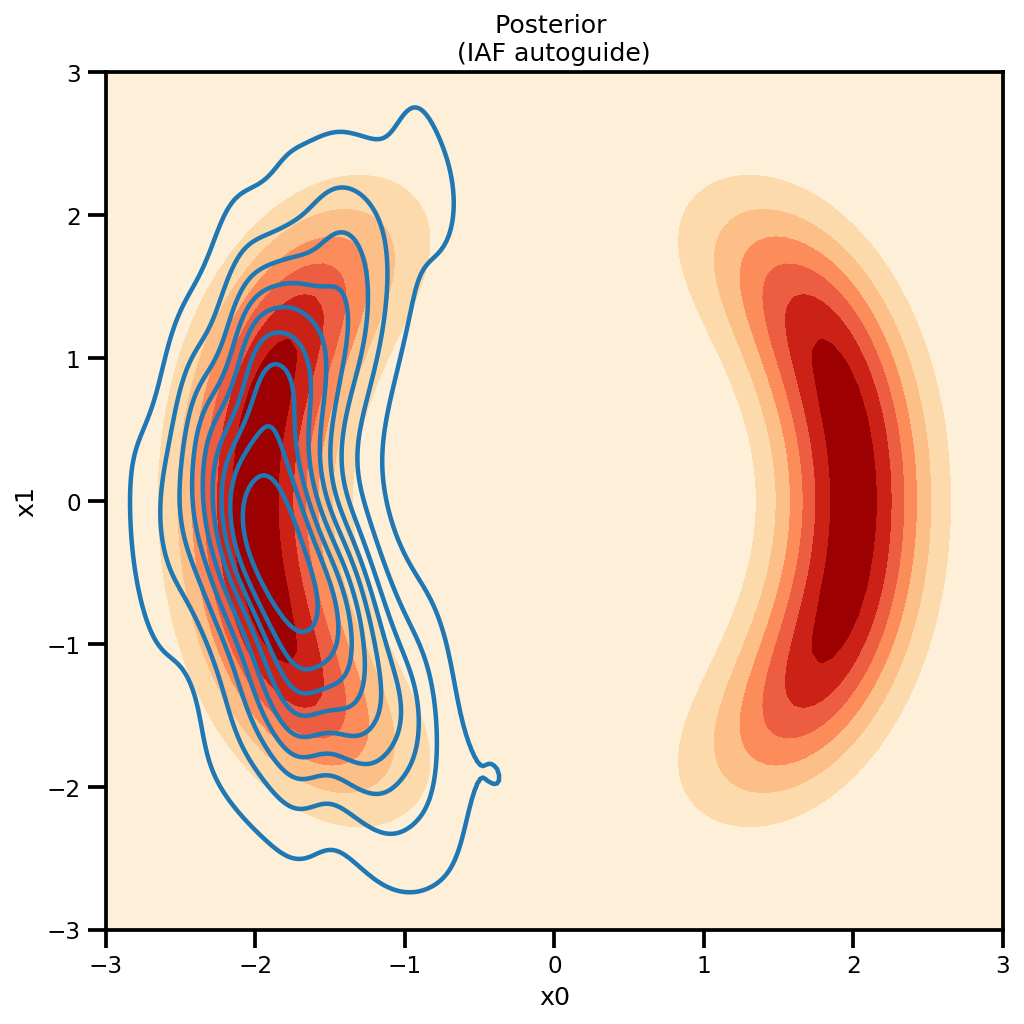

In [78]:
fig, ax = plt.subplots(figsize=(7, 7), constrained_layout=True)


ax.contourf(x1, x2, p, cmap="OrRd")
ax.set(
    xlabel="x0",
    ylabel="x1",
    xlim=xlim,
    ylim=ylim,
    title="Posterior \n(IAF autoguide)",
)

sns.kdeplot(autoiaf_samples[:, 0], autoiaf_samples[:, 1], ax=ax)
plt.show()